In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data cleaning and preparation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import confusion_matrix, plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix

import os, sys
sys.path.append('../')

# Helper functions
from src import helper

## Data Cleaning
Our EDA showed that of our 41 columns (remember that `instance ignore` was dropped per metadata instructions):
- 8 were numeric
- 33 were categorical, including our target

Additionally:
- 15 features had missing values, designated by 'Not in universe' instead of the typical 'nan'
- 6 features have > 90% of values missing!
- 55992 observations are for individuals under the age of 18, which is likely why `industry_code` and `occupation_code` are missing. We could easily fill these in with our own label

<b>Dropping Features</b>
- For a first pass of our data, let's drop the columns with >90% of the data missing. The columns don't appear to be highly related to income, making me reasonably comfortable that they can be excluded for a first pass. 
- `fill_quest_va`	
- `reason_unemploy`	
- `enrolled_edu`
- `residence_region`	
- `residence_state`
- `union_mem`
- `migration_sunbelt`


We also saw when doing EDA that occupation and industry code seemed relevant, although these 4 are highly related and we can get away with just keeping one of them. Based on the bar chart looking at income, we can keep
`occupation_code_detailed` and drop the other 3.
Similarly, we can get rid of `household_descr` as it overlaps with `household_summary`

<b>Imputing Data</b>

- `country_father`, `country_mother`, and `country_self`, roughly 1-3% of the data is missing, so we can fill in with the mode of each feature or drop those data. 

<b>Other Considerations</b>
- `class` is missing ~50% of the data and this appears to be an important feature, so we can keep 'Not in universe' as it's own label.
- `migration_reg`, along with `migration_move_reg` and `migration_msa` are all missing ~50% of values. Again, we can treat '?' as it's own label. I would not group the '?' with 'Not in universe' based on EDA results showing different income splits amongst those two labels. 

- `live_residence1_yr` has the labels of 'yes', 'no', and 'Not in universe under 1yr'. The last label *indicates* less than 1 year, but this makes one wonder why the two different 'no' classes. Again, we can make another class. 

- Numeric features will need to be normalized.

<b>Model Considerations</b>

When cleaning data, it's useful to think about the models that we'll be using and what the constraints on the data might be. Some more advanced models, like CatBoost, can handle string labels, so there is no need to bother with OHE or Label Encoding. Tree based models, like RandomForest and XGBoost, handle label encoding better than Linear/Logistic Regression due to the splits treating numeric and categorical data the same. Linear/Logistic Regression are sensitive to collinearity as a singular matrix cannot be inverted. With the high dimensionality we get from OHE, we can use L1 regularization to reduce dimensionality instead of using PCA prior to modeling. 

If we have a mix of categorical and numeric features and have employed OHE for our categorical variables, we need to be careful when running a tree-based model that only splits on a subset of features as it's possible we'll end up not using our numeric features. We can mitigate this by running PCA prior to implementing the tree-based model to get the dimensionality down. 

In [2]:
# Import data and get columns from metadata
cols = pd.read_csv('../data/columns.csv', names=['labels'])
data = pd.read_csv('../data/census_income_learn.csv', names=cols['labels'].values).drop(columns=['instance_ignore'])

In [3]:
data.head()

,age,class,industry_code_detailed,occupation_code_detailed,education,wage,enrolled_edu,marital_status,industry_code_major,occupation_code_major,...,country_father,country_mother,country_self,citizenship,own_business,fill_quest_va,veterans_benefits,weeks_worked_yr,year,income
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
drop_list = ['fill_quest_va', 'reason_unemploy', 'enrolled_edu', 'residence_region', 'residence_state', 'union_mem',
        'migration_sunbelt', 'occupation_code_major', 'industry_code_major', 'industry_code_detailed', 'household_descr']

data.drop(columns=drop_list, inplace=True)
data.head()

,age,class,occupation_code_detailed,education,wage,marital_status,race,hispanic,sex,employment_stat,...,family_under18,country_father,country_mother,country_self,citizenship,own_business,veterans_benefits,weeks_worked_yr,year,income
0,73,Not in universe,0,High school graduate,0,Widowed,White,All other,Female,Not in labor force,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,2,0,95,- 50000.
1,58,Self-employed-not incorporated,34,Some college but no degree,0,Divorced,White,All other,Male,Children or Armed Forces,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,2,52,94,- 50000.
2,18,Not in universe,0,10th grade,0,Never married,Asian or Pacific Islander,All other,Female,Not in labor force,...,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,2,0,95,- 50000.
3,9,Not in universe,0,Children,0,Never married,White,All other,Female,Children or Armed Forces,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,0,0,94,- 50000.
4,10,Not in universe,0,Children,0,Never married,White,All other,Female,Children or Armed Forces,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,0,0,94,- 50000.


## Label encoding our target, imputing missing data, and creating pipeline for OHE and Standardization

Note: OHE works best for Logistic Regression, but not for forest-based models due to the sparse matrix. 
Our pipeline is:
1. Separate out the X, y components from our dataset.
2. Label encode our y, with 0 representing our class of income < 50k and 1 representing our minority class with income > 50k.
3. Preprocess our X:
    -  Impute missing data for the country of mother, father, self.
    - Standardize numerical features.
    - OHE categorical features for logistic regression OR do Ordinal encoding for tree based models.
    - Fit on our training data, and transform both our training and test data.


In [5]:
# Get X, y and label encode target
X, y = data.drop(columns='income'), data['income']
le = LabelEncoder().fit(y)
y = le.transform(y)
print(f'Our classes are: {le.classes_[0]} for the 0 class and {le.classes_[1]} for the 1 class') 

Our classes are:  - 50000. for the 0 class and  50000+. for the 1 class


In [6]:
# Impute country_father, country_mother, country_self
X = helper.impute_countries(X)

# Get column numbers of categorical/numerical features for column transformer
numerical = ['age', 'wage', 'capital_gains', 'capital_losses', 'dividends', 'num_persons_worked_employer', 'weeks_worked_yr', 'year']
categorical = ['class', 'occupation_code_detailed', 'education', 'marital_status', 'race', 'hispanic', 'sex',
               'employment_stat',  'tax_filer_stat', 'household_summary', 'migration_msa', 'migration_reg',
               'migration_move_reg', 'live_residence_1yr', 'family_under18', 'country_father', 'country_mother',
               'country_self', 'citizenship', 'own_business', 'veterans_benefits']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Preprocess our data by fitting transformer on training set
# 'ohe' flag is for OneHotEncoding for Logistic Regression
transformer, feature_names = helper.preprocess(X_train, categorical, numerical, ohe=False)
X_train, X_test = transformer.transform(X_train), transformer.transform(X_test)

## Modeling
We now have our training and test set ready for modeling. We're going to utilize stratified k-fold technique to get our AUC metric. Once we see how some of the models perform out of the box, we can start optimization. 

1. Logistic Regression with L1/Lasso regularization to push many coefficients to 0
2. Random Forest
3. XGBoost

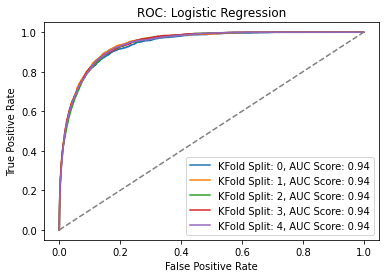

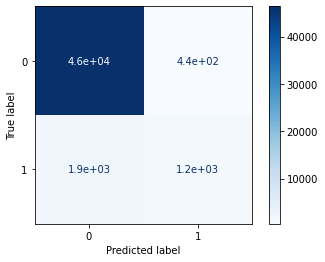

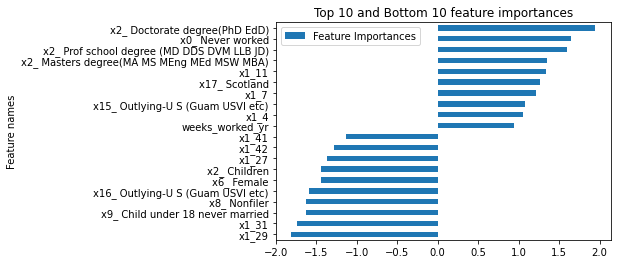

Precision: 0.7284562926224426 
, Recall: 0.3842380640941792 
, F1: 0.5031042603296938 
, Mean_Auc: 0.9424168436616673 



In [148]:
# Logistic Regression Model Performance
model = LogisticRegression(penalty='l1', solver='liblinear')
mean_auc = helper.plot_roc(X_train, y_train, model, "Logistic Regression")
precision, recall, f1, importances = helper.compile_metrics(X_train, X_test, y_train, y_test, model, log=True)

# Plot feature importances
helper.feature_importances(feature_names, importances, 'lr')

print(f'Precision: {precision} \n, Recall: {recall} \n, F1: {f1} \n, Mean_Auc: {mean_auc} \n')

While the AUC is great, it's a little misleading. Our precision is ok, but our recall isn't great, leading to an overall f1-score of 0.49. Looking at the confusion matrix shows that we have A LOT of False Negatives; we are classifying many points as making < 50k when the true label is > 50k. Our false positive rate is low, which is why our AUC looks so good. 

We can try lowering the threshold for predicting classes. This can be done visually by looking at the precision/recall chart.

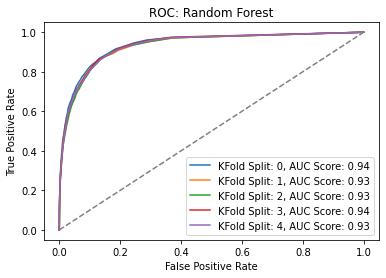

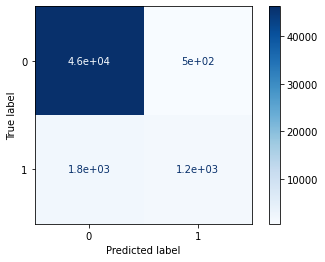

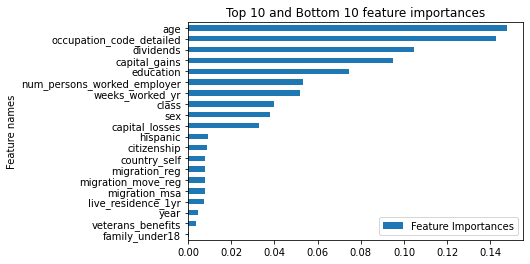

Precision: 0.7134604274985558 
, Recall: 0.40491803278688526 
, F1: 0.5166283204350555 
, Mean_Auc: 0.9339357296406329 



In [150]:
# Random Forest
model = RandomForestClassifier(n_estimators=100)
mean_auc = helper.plot_roc(X_train, y_train, model, "Random Forest")
precision, recall, f1, importances = helper.compile_metrics(X_train, X_test, y_train, y_test, model, log=False)

# Feature Importances
helper.feature_importances(feature_names, importances, 'rf')

print(f'Precision: {precision} \n, Recall: {recall} \n, F1: {f1} \n, Mean_Auc: {mean_auc} \n')

While our AUC is negligibly lower, our recall and f1 is a little higher. This model predicts positive classes at a higher rate. 

#### Optimization
We can use RandomizedSearchCV to optimize the hyperparameters for random forest. 
The scoring parameter can be changed to optimize for recall or f1 score, which is going to give a better meausre of how the model performs on an imbalanced dataset. 
Additonally, we can add a class weight to optimize for accurately classifying the positive class

In [59]:
# Define parameters for searching
params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [20, 30],
    'max_features': [10, 20],
    'class_weight': [{0:1, 1:1}, {0:1, 1:3}, {0:1, 1:5}]
}

# Search for best model
clf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, n_jobs=-1, scoring='f1')
clf.fit(X_train, y_train)
clf.best_estimator_, clf.best_params_, clf.best_score_

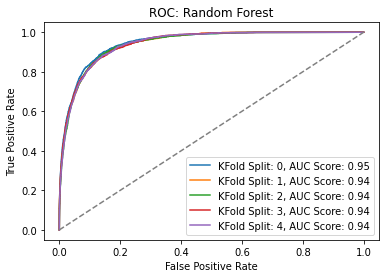

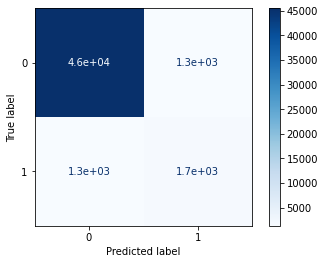

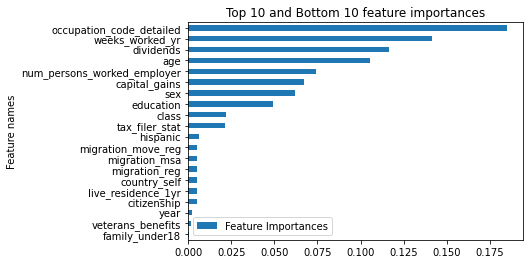

Precision: 0.5676296782665792 
, Recall: 0.5668852459016394 
, F1: 0.5672572178477691 
, Mean_Auc: 0.9437757010943999 



In [153]:
# Rerun with best model!
model = RandomForestClassifier(n_estimators=500, max_depth=20, max_features=10, class_weight={0:1, 1:5})
mean_auc = helper.plot_roc(X_train, y_train, model, "Random Forest")
precision, recall, f1, importances = helper.compile_metrics(X_train, X_test, y_train, y_test, model, log=False)

# Feature Importances
helper.feature_importances(feature_names, importances, 'rf')

print(f'Precision: {precision} \n, Recall: {recall} \n, F1: {f1} \n, Mean_Auc: {mean_auc} \n')

### XGBoost

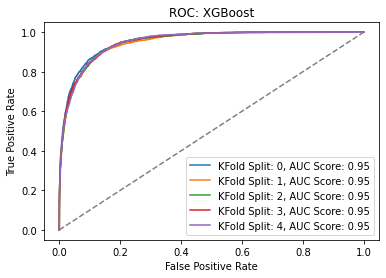

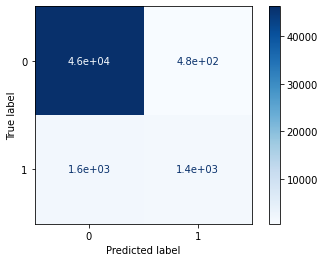

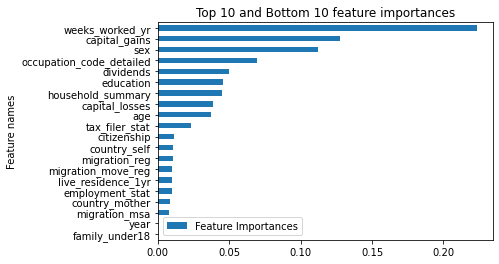

Precision: 0.7486910994764397 
, Recall: 0.46885245901639344 
, F1: 0.5766129032258065 
, Mean_Auc: 0.9520612051510134 



In [151]:
model = XGBClassifier()
model.fit(X_train, y_train)

mean_auc = helper.plot_roc(X_train, y_train, model, "XGBoost")
precision, recall, f1, importances = helper.compile_metrics(X_train, X_test, y_train, y_test, model, log=False)

# Feature Importances
helper.feature_importances(feature_names, importances, 'xgb')

print(f'Precision: {precision} \n, Recall: {recall} \n, F1: {f1} \n, Mean_Auc: {mean_auc} \n')

#### Optimization

In [87]:
# Define parameters for searching
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [88]:
# Search for best model
clf = GridSearchCV(XGBClassifier(), param_grid=params, cv=5, n_jobs=-1, scoring='f1')
clf.fit(X_train, y_train)
clf.best_estimator_, clf.best_params_, clf.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=5,
               min_child_weight=5, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=1,
               objective='binary:logistic', random_state=0, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, subsample=1.0,
               tree_method='exact', validate_parameters=1, verbosity=None),
 {'colsample_bytree': 1.0,
  'gamma': 0.5,
  'max_depth': 5,
  'min_child_weight': 5,
  'subsample': 1.0},
 0.5752404123466034)

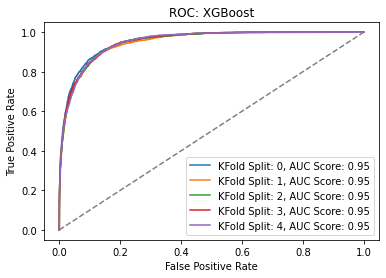

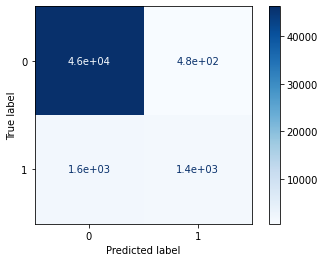

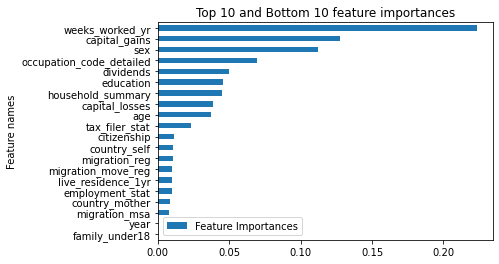

Precision: 0.7486910994764397 
, Recall: 0.46885245901639344 
, F1: 0.5766129032258065 
, Mean_Auc: 0.9520612051510134 



In [152]:
# Rerun with best model!
model = XGBClassifier()
mean_auc = helper.plot_roc(X_train, y_train, model, "XGBoost")
precision, recall, f1, importances = helper.compile_metrics(X_train, X_test, y_train, y_test, model, log=False)

# Feature Importances
helper.feature_importances(feature_names, importances, 'xgb')

print(f'Precision: {precision} \n, Recall: {recall} \n, F1: {f1} \n, Mean_Auc: {mean_auc} \n')

### Peformance on Test Data

Let's run the test data through our best model.

In [130]:
# Import our training/testing data
cols = pd.read_csv('../data/columns.csv', names=['labels'])
data = pd.read_csv('../data/census_income_learn.csv', names=cols['labels'].values).drop(columns=['instance_ignore'])
data_test = pd.read_csv('../data/census_income_test.csv').drop(columns=['instance_ignore'])

# Drop columns
drop_list = ['fill_quest_va', 'reason_unemploy', 'enrolled_edu', 'residence_region', 'residence_state', 'union_mem',
        'migration_sunbelt', 'occupation_code_major', 'industry_code_major', 'industry_code_detailed', 'household_descr']
data_test.drop(columns=drop_list, inplace=True)
data.drop(columns=drop_list, inplace=True)

# Split into X and y and label encode y
X_test, y_test = data_test.drop(columns='income'), data_test['income']
X_train, y_train = data.drop(columns='income'), data['income']

le = LabelEncoder()
le.fit(y_train)
y_test, y_train = le.transform(y_test), le.transform(y_train)

# Fill in missing countries
X_train, X_test = helper.impute_countries(X_train), helper.impute_countries(X_test)

# Preprocess data using transformer fit on training data
numerical = ['age', 'wage', 'capital_gains', 'capital_losses', 'dividends', 'num_persons_worked_employer', 'weeks_worked_yr', 'year']
categorical = ['class', 'occupation_code_detailed', 'education', 'marital_status', 'race', 'hispanic', 'sex',
               'employment_stat',  'tax_filer_stat', 'household_summary', 'migration_msa', 'migration_reg',
               'migration_move_reg', 'live_residence_1yr', 'family_under18', 'country_father', 'country_mother',
               'country_self', 'citizenship', 'own_business', 'veterans_benefits']
transformer, feature_names = helper.preprocess(X_train, categorical, numerical, ohe=False)
X_train, X_test = transformer.transform(X_train), transformer.transform(X_test)

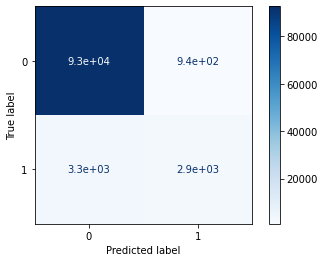

(0.7554163403811015, 0.46783058519236986, 0.5778177098931817)

In [137]:
# Define model, train, predict, and get metrics
model = XGBClassifier()
model.fit(X_train, y_train)
precision, recall, f1, importances = helper.compile_metrics(X_train, X_test, y_train, y_test, model)
print(f'Precision: {precision} \n, Recall: {recall} \n, F1: {f1} \n, Mean_Auc: {mean_auc} \n')

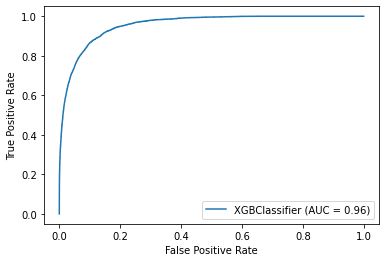

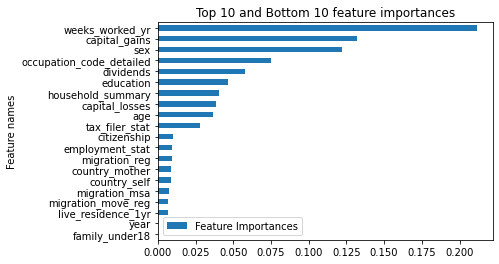

<Figure size 432x288 with 0 Axes>

In [139]:
# Plot ROC and feature importances
plot_roc_curve(model, X_test, y_test)
plt.savefig('../images/roc_best.png', dpi=250)
helper.feature_importances(feature_names, importances, 'best')